# BAF633 시뮬레이션 hw2

20249433 최재필

전략: 

1. MCS Variance Reduction 적용
    - Browninan Bridge; vectorized ver. 
        - down-out, up-out을 먼저 구한 뒤 in-out-parity로 in을 구한다. 
        - Brownian Bridge를 vectorized 방법으로 쓸 경우 vectorized numpy operation을 쓰더라도 path 자체를 줄일 수 있다. 
    - Antithetic Variates
        - terminal payoff 함수가 straddle 모양이 아니기 때문에 사용 가능
    - 난수 추출
        - pseudo-random 써야함. (antithetic variates 쓰기에)
            - 어차피 과제에서 quasi-random은 안쓰게 되어있음
        - input 단에선 그냥 numpy 기본 random 쓰면 될듯. (Ziggurat)
        - Normal dist를 뽑을 때는 내가 stratified sampling 안해도 최적화 되어있겠지? --> 궁금해하지 말고 확인. 
    - terminal stratification
        - Brownian Bridge를 위해 terminal에서 뽑을 때 stratification 적용해서 추출
    - importance sampling
2. CS Performance Optimization 적용
    - cacheing 캐싱
    - parallelization 병렬화 (multiprocessing)
    - numba
        - iterative process 들어가는 경우 효과적
        - simple vectorized 연산으로만 이뤄지는 경우 효과 떨어짐
        - small dataset에서는 numba compile overhead 때문에 퍼포먼스 떨어질 수 있음. 


고려사항:

- 교수님 실행 환경. conda base python 3.12 인 것을 확인. conda base에는 numba, numexpr 등이 깔려있음. 그러나 사용가능하게 해주실지는 잘 모르겠음. 




# Import libs

In [1]:
import QuantLib as ql

import numpy as np

from numba import njit
import numexpr as ne

from functools import lru_cache

import multiprocessing as mp

# import cProfile # Use line_profiler instead.
import time

## Useful tricks

In [2]:
# inplace operation is faster than creating a new array

large_array = np.random.rand(1000, 1000)
large_array.cumsum(axis=1, out=large_array) 


array([[5.20318147e-02, 7.08604271e-01, 9.97928109e-01, ...,
        5.13891802e+02, 5.14291853e+02, 5.14415860e+02],
       [6.56707067e-03, 7.36349120e-01, 1.51413677e+00, ...,
        4.88558568e+02, 4.89538865e+02, 4.90465578e+02],
       [2.14590125e-01, 9.38786012e-01, 1.04054899e+00, ...,
        4.94346763e+02, 4.94916837e+02, 4.95907134e+02],
       ...,
       [3.57259975e-02, 7.27384733e-01, 1.58882586e+00, ...,
        5.00233303e+02, 5.00480616e+02, 5.00947717e+02],
       [3.19415909e-01, 8.40695114e-01, 1.23746683e+00, ...,
        4.90974666e+02, 4.91772424e+02, 4.92348654e+02],
       [3.43564165e-01, 6.83748088e-01, 1.19143484e+00, ...,
        5.05968151e+02, 5.06625930e+02, 5.06922691e+02]])

In [3]:
## numba njit compilation 시간 많이 걸림. vectorize로 할 수 있으면 무조건 그거 써야 함. 
## numpy는 이미 internal optimization이 잘 되어있음. 
## vectorize로 안되고 부득이 iteration을 써야 할 때만 numba 쓰자.

# Plain np.cumsum
start_time = time.time()
plain_cumsum_result = np.cumsum(large_array)
plain_cumsum_time = time.time() - start_time

# @njit optimized cumsum
@njit
def cumulative_sum(arr):
    return np.cumsum(arr)

start_time = time.time()
njit_cumsum_result = cumulative_sum(large_array)
njit_cumsum_time = time.time() - start_time

print(f"Plain np.cumsum time: {plain_cumsum_time} seconds")
print(f"@njit optimized cumsum time: {njit_cumsum_time} seconds")

Plain np.cumsum time: 0.005997896194458008 seconds
@njit optimized cumsum time: 2.1239545345306396 seconds


## Baseline

교수님 MCS code가 baseline

In [4]:
#%%
import numpy as np
import time 

def mc_barrier_price_baseline(s,k,r,q,t,sigma,option_flag,nsim,b,barrier_flag,m):
    dt = t/m
    z = np.random.randn(nsim,m)
    z = z.cumsum(1)
    dts = np.arange(dt,t+dt,dt)
    st = s*np.exp((r-q-0.5*sigma**2)*dts + sigma*np.sqrt(dt)*z)
    barrier_knock = st.max(1)>=b if barrier_flag.split("-")[0].lower()=='up' else st.min(1)<=b
    if barrier_flag.split('-')[1].lower()=="out": 
        barrier_knock = ~barrier_knock
    callOrPut = 1 if option_flag.lower()=='call' else -1
    payoff = np.maximum(callOrPut*(st[:,-1]-k), 0) * barrier_knock
    disc_payoff = np.exp(-r*t)*payoff
    price = disc_payoff.mean()    
    # se = disc_payoff.std(ddof=1) / np.sqrt(nsim)
    return price


## GPT Implementations

promt:



> ---
> 
> Okay. Now that you have seen all the code, here's what I want to do:
> 
> I want to make `mc_barrier_price` like below:
> 
> ```python
> def mc_barrier_price(s, k, r, q, t, sigma, option_flag, n, b, barrier_flag, m):
>     callOrPut = 1 if option_flag == 'call' else -1
>     upOrDown, inOrOut = barrier_flag.split('-')
>     upOrDown = 1 if upOrDown == 'up' else -1
>     inOrOut = 1 if inOrOut == 'in' else 0
> ```
> 
> My goals are:
> - Make the bias as low as possible
> - Make the variance as low as possible
> - I know there's an inherent bias-variance trade-off, so I'm actually looking for a pareto-optimal improvement. Variance should become lower without hurting the bias. i.e., the variance reduction technique should be unrelated to `m` & `n` parameter choices.
> - Make the function run faster. (Important)
> 
> However, you can't use low discrepancy sequences for quasi-random number sampling.
> 
> Here are the techniques I want to apply:
> 
> - **Vectorized Brownian Bridge with In-Out Parity:**  
>   Implement vectorized Brownian Bridge by sampling from the maturity's terminal price distributions and rule out any knocked-out paths in advance. Then, build the Brownian bridge in the midpoint of each selected sample by connecting them to the initial price, `s`.  
>   Now that you have midpoints, these are the center of the normal distribution at the midpoint. Sample data points from this midpoint and again rule out anything that's knocked off. With the remaining data points, you build a Brownian Bridge path connecting the starting point, the midpoint, and the terminal point.  
>   
>   This should reduce the number of path simulations, so it should be able to speed up the whole simulation.
>   
>   *Note*: This method calculates **out options** first. In options cannot be calculated in this way because they must be tracked until maturity to monitor whether they stay under/over the barrier. This is where **In-Out parity** is applied. Use the `bsprice` function imported above to calculate the vanilla call/put option, then subtract the out option to automatically get the in option.  
>   
>   i.e., you should always calculate for out options regardless of user inputs.
> 
> - **Antithetic Variates:**  
>   Use very-easy-to-implement antithetic variates by flipping half of the initial Z samples.
> 
> - **Importance Sampling:**  
>   Shift the sampling distribution near the strike price, `K`, **only if** the option is projected to be OTM or ITM. Implement logic to choose the optimal shift.
> 
> - **Control Variates:**  
>   Use the BS price at time `t` as a control variate. Apply control variates to lower the variance.
> 
> ---
> 
> Remember that the code should have clear comments to show which technique you're using. Before writing the code, tell me your overall plan to implement this in Python using `numpy`.

In [5]:
import numpy as np
from blackscholes import bsprice

def mc_barrier_price1(s, k, r, q, t, sigma, option_flag, n, b, barrier_flag, m):
    """
    Monte Carlo pricing of barrier options with variance reduction techniques.

    Parameters:
        s (float): Initial stock price.
        k (float): Strike price.
        r (float): Risk-free interest rate.
        q (float): Dividend yield.
        t (float): Time to maturity.
        sigma (float): Volatility.
        option_flag (str): 'call' or 'put'.
        n (int): Number of simulation paths.
        b (float): Barrier level.
        barrier_flag (str): 'up-in', 'up-out', 'down-in', or 'down-out'.
        m (int): Number of time steps for discretization.

    Returns:
        float: Estimated option price.
    """
    # Parse option type and barrier characteristics
    callOrPut = 1 if option_flag.lower() == 'call' else -1
    upOrDown, inOrOut = barrier_flag.lower().split('-')
    upOrDown = 'up' if upOrDown == 'up' else 'down'
    inOrOut = 'in' if inOrOut == 'in' else 'out'

    dt = t / m  # Time step
    drift = (r - q - 0.5 * sigma ** 2) * dt
    vol = sigma * np.sqrt(dt)

    # Generate standard normal random variables
    n_half = n // 2
    z = np.random.randn(n_half, m)
    # Antithetic variates
    z = np.vstack((z, -z))

    # Importance sampling (optional, depending on option characteristics)
    # Skipping importance sampling for simplicity here

    # Simulate paths
    increments = drift + vol * z
    log_s = np.log(s) + np.cumsum(increments, axis=1)
    s_paths = np.exp(log_s)

    # Include initial price
    s_paths = np.hstack((s * np.ones((n, 1)), s_paths))

    # Check for barrier crossing
    if upOrDown == 'up':
        if inOrOut == 'out':
            barrier_crossed = np.any(s_paths >= b, axis=1)
            payoff_paths = np.where(barrier_crossed, 0.0, np.maximum(callOrPut * (s_paths[:, -1] - k), 0))
        else:  # 'in' option
            barrier_crossed = np.any(s_paths >= b, axis=1)
            payoff_paths = np.where(barrier_crossed, np.maximum(callOrPut * (s_paths[:, -1] - k), 0), 0.0)
    else:  # 'down'
        if inOrOut == 'out':
            barrier_crossed = np.any(s_paths <= b, axis=1)
            payoff_paths = np.where(barrier_crossed, 0.0, np.maximum(callOrPut * (s_paths[:, -1] - k), 0))
        else:  # 'in' option
            barrier_crossed = np.any(s_paths <= b, axis=1)
            payoff_paths = np.where(barrier_crossed, np.maximum(callOrPut * (s_paths[:, -1] - k), 0), 0.0)

    # Discount payoffs
    disc_payoffs = np.exp(-r * t) * payoff_paths

    # Control Variates: Use the vanilla option as control variate
    # Compute the analytical price and the simulated vanilla payoffs
    vanilla_price = bsprice(s, k, r, q, t, sigma, option_flag)

    # Simulate vanilla option payoffs (without considering the barrier)
    vanilla_payoffs = np.maximum(callOrPut * (s_paths[:, -1] - k), 0)
    disc_vanilla_payoffs = np.exp(-r * t) * vanilla_payoffs

    # Compute covariance and adjust payoffs
    cov = np.cov(disc_payoffs, disc_vanilla_payoffs)
    beta = cov[0, 1] / cov[1, 1]
    adjusted_payoffs = disc_payoffs - beta * (disc_vanilla_payoffs - vanilla_price)

    # Estimate price
    price = np.mean(adjusted_payoffs)

    return price


In [6]:
import numpy as np
from blackscholes import bsprice

def mc_barrier_price2(s, k, r, q, t, sigma, option_flag, n, b, barrier_flag, m):
    """
    Monte Carlo pricing of barrier options with variance reduction techniques,
    including Importance Sampling.

    Parameters:
        s (float): Initial stock price.
        k (float): Strike price.
        r (float): Risk-free interest rate.
        q (float): Dividend yield.
        t (float): Time to maturity.
        sigma (float): Volatility.
        option_flag (str): 'call' or 'put'.
        n (int): Number of simulation paths.
        b (float): Barrier level.
        barrier_flag (str): 'up-in', 'up-out', 'down-in', or 'down-out'.
        m (int): Number of time steps for discretization.

    Returns:
        float: Estimated option price.
    """
    # Parse option type and barrier characteristics
    callOrPut = 1 if option_flag.lower() == 'call' else -1
    upOrDown, inOrOut = barrier_flag.lower().split('-')
    upOrDown = 'up' if upOrDown == 'up' else 'down'
    inOrOut = 'in' if inOrOut == 'in' else 'out'

    dt = t / m  # Time step
    drift = (r - q - 0.5 * sigma ** 2) * dt
    vol = sigma * np.sqrt(dt)

    # Determine Importance Sampling shift (mu)
    # For barrier options, shifting towards the barrier can increase the probability of crossing
    if upOrDown == 'up':
        # Shift upwards for 'up' barriers
        mu = (np.log(b/s) - drift * m) / (vol * np.sqrt(m))
    else:
        # Shift downwards for 'down' barriers
        mu = (np.log(b/s) - drift * m) / (vol * np.sqrt(m))

    # Generate standard normal random variables
    n_half = n // 2
    z = np.random.randn(n_half, m)
    # Antithetic variates
    z = np.vstack((z, -z))

    # Apply Importance Sampling shift
    z_shifted = z + mu
    # Compute the likelihood ratio for the entire path
    # Since the path consists of m steps, the likelihood ratio is the product of individual step ratios
    # Assuming independence, it simplifies to exp(-mu*z_shifted + 0.5*mu**2)*m
    # However, for simplicity, we approximate it per path
    lr = np.exp(-mu * z_shifted + 0.5 * mu**2)
    # Sum log-likelihood ratios across all steps to get total likelihood ratio per path
    total_lr = np.prod(lr, axis=1)

    # Simulate paths with shifted z
    increments = drift + vol * z_shifted
    log_s = np.log(s) + np.cumsum(increments, axis=1)
    s_paths = np.exp(log_s)

    # Include initial price
    s_paths = np.hstack((s * np.ones((n, 1)), s_paths))

    # Check for barrier crossing
    if upOrDown == 'up':
        if inOrOut == 'out':
            barrier_crossed = np.any(s_paths >= b, axis=1)
            payoff_paths = np.where(barrier_crossed, 0.0, np.maximum(callOrPut * (s_paths[:, -1] - k), 0))
        else:  # 'in' option
            barrier_crossed = np.any(s_paths >= b, axis=1)
            payoff_paths = np.where(barrier_crossed, np.maximum(callOrPut * (s_paths[:, -1] - k), 0), 0.0)
    else:  # 'down'
        if inOrOut == 'out':
            barrier_crossed = np.any(s_paths <= b, axis=1)
            payoff_paths = np.where(barrier_crossed, 0.0, np.maximum(callOrPut * (s_paths[:, -1] - k), 0))
        else:  # 'in' option
            barrier_crossed = np.any(s_paths <= b, axis=1)
            payoff_paths = np.where(barrier_crossed, np.maximum(callOrPut * (s_paths[:, -1] - k), 0), 0.0)

    # Discount payoffs and apply likelihood ratio
    disc_payoffs = np.exp(-r * t) * payoff_paths * total_lr

    # Control Variates: Use the vanilla option as control variate
    # Compute the analytical price and the simulated vanilla payoffs
    vanilla_price = bsprice(s, k, r, q, t, sigma, option_flag)

    # Simulate vanilla option payoffs (without considering the barrier)
    vanilla_payoffs = np.maximum(callOrPut * (s_paths[:, -1] - k), 0)
    disc_vanilla_payoffs = np.exp(-r * t) * vanilla_payoffs * total_lr

    # Compute covariance and adjust payoffs
    cov_matrix = np.cov(disc_payoffs, disc_vanilla_payoffs)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    adjusted_payoffs = disc_payoffs - beta * (disc_vanilla_payoffs - vanilla_price)

    # Estimate price
    price = np.mean(adjusted_payoffs)

    return price


Estimated up-out call option price: 2.2733


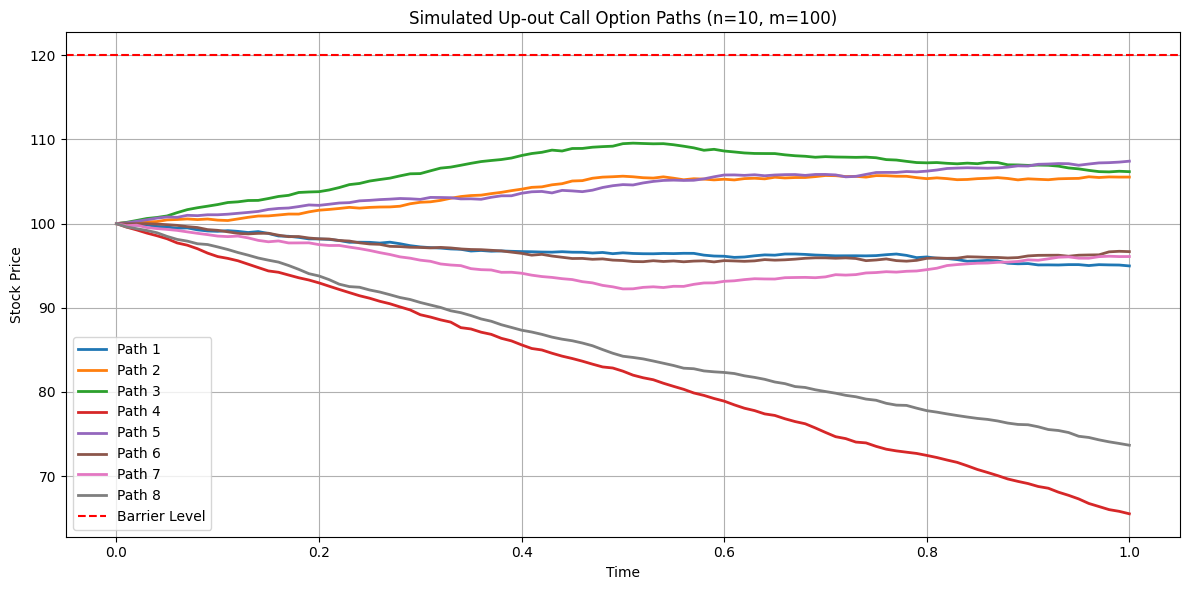

In [6]:
import numpy as np
import matplotlib.pyplot as plt
# from blackscholes import bsprice  # Uncomment if needed

def simulate_multiple_brownian_bridges(start_points, end_points, m=100, T=1.0):
    """
    Simulates multiple Brownian bridges.

    Parameters:
    - start_points: List or array of starting points.
    - end_points: List or array of ending points.
    - m: Number of time steps.
    - T: Total time duration.

    Returns:
    - t: Time points array.
    - bridges: Simulated bridges array.
    """
    if len(start_points) != len(end_points):
        raise ValueError("start_points and end_points must have the same length.")
    
    n_bridges = len(start_points)
    start_points = np.array(start_points).reshape(n_bridges, 1)
    end_points = np.array(end_points).reshape(n_bridges, 1)
    
    dt = T / m
    t = np.linspace(0, T, m + 1)
    
    dW = np.random.normal(0.0, np.sqrt(dt), size=(n_bridges, m))
    W = np.cumsum(dW, axis=1)
    W = np.hstack((np.zeros((n_bridges, 1)), W))
    
    t_over_T = t / T
    t_over_T = t_over_T.reshape(1, -1)
    
    bridges = W - t_over_T * W[:, -1].reshape(n_bridges, 1)
    bridges += start_points + t_over_T * (end_points - start_points)
    
    return t, bridges

def mc_barrier_price2(s, k, r, q, t_total, sigma, option_flag, n, b, barrier_flag, m):
    """
    Monte Carlo pricing of barrier options using Brownian Bridge and antithetic variates.

    Parameters:
        s (float): Initial stock price.
        k (float): Strike price.
        r (float): Risk-free interest rate.
        q (float): Dividend yield.
        t_total (float): Time to maturity.
        sigma (float): Volatility.
        option_flag (str): 'call' or 'put'.
        n (int): Number of simulation paths.
        b (float): Barrier level.
        barrier_flag (str): 'up-in', 'up-out', 'down-in', or 'down-out'.
        m (int): Number of time steps.

    Returns:
        float: Estimated option price.
        np.ndarray: Simulated paths.
    """
    callOrPut = 1 if option_flag.lower() == 'call' else -1
    upOrDown, inOrOut = barrier_flag.lower().split('-')
    upOrDown = 'up' if upOrDown == 'up' else 'down'
    inOrOut = 'in' if inOrOut == 'in' else 'out'

    drift = (r - q - 0.5 * sigma**2) * t_total
    diffusion_coeff = sigma * np.sqrt(t_total)

    n_half = n // 2
    Z = np.random.randn(n_half)
    Z = np.concatenate((Z, -Z))

    S_T = s * np.exp(drift + diffusion_coeff * Z)

    if upOrDown == 'up':
        survived_indices = np.where(S_T < b)[0]
    else:
        survived_indices = np.where(S_T > b)[0]

    S_T_survived = S_T[survived_indices]
    Z_survived = Z[survived_indices]

    t_mid = t_total / 2
    mu_mid = (np.log(s) + np.log(S_T_survived)) / 2
    sigma_mid = sigma * np.sqrt(t_mid * (t_total - t_mid) / t_total)

    n_survived = len(S_T_survived)
    n_mid_half = n_survived // 2
    epsilon = np.random.randn(n_mid_half)
    epsilon = np.concatenate((epsilon, -epsilon))
    if len(epsilon) < n_survived:
        epsilon = np.concatenate((epsilon, [0]))

    ln_S_mid = mu_mid + sigma_mid * epsilon[:n_survived]
    S_mid = np.exp(ln_S_mid)

    if upOrDown == 'up':
        survived_indices_mid = np.where(S_mid < b)[0]
    else:
        survived_indices_mid = np.where(S_mid > b)[0]

    S_T_final = S_T_survived[survived_indices_mid]
    S_mid_final = S_mid[survived_indices_mid]

    # Define the number of steps for each Brownian bridge segment
    m_bridge = m // 2
    if m % 2 != 0:
        m_bridge += 1

    # Prepare start and end points for both bridge segments
    start_points_bridge1 = np.full(len(S_mid_final), s)
    end_points_bridge1 = S_mid_final

    start_points_bridge2 = S_mid_final
    end_points_bridge2 = S_T_final

    # Simulate the first set of Brownian bridges (s to S_mid_final)
    t_bridge1, bridge1 = simulate_multiple_brownian_bridges(
        start_points=start_points_bridge1,
        end_points=end_points_bridge1,
        m=m_bridge,
        T=t_mid
    )

    # Simulate the second set of Brownian bridges (S_mid_final to S_T_final)
    t_bridge2, bridge2 = simulate_multiple_brownian_bridges(
        start_points=start_points_bridge2,
        end_points=end_points_bridge2,
        m=m - m_bridge,
        T=t_total - t_mid
    )

    # Concatenate the two bridge segments to form complete paths
    bridge1_trimmed = bridge1[:, :-1]
    bridge2_trimmed = bridge2
    final_paths = np.hstack((bridge1_trimmed, bridge2_trimmed))

    # Calculate the option payoffs based on the final stock prices
    payoffs = np.maximum(callOrPut * (S_T_final - k), 0)

    if inOrOut == 'in':
        n_in = n - len(S_T_final)
        if n_in > 0:
            in_payoffs = np.maximum(callOrPut * (S_T[survived_indices] - k), 0)
            option_price = np.exp(-r * t_total) * np.mean(in_payoffs)
        else:
            option_price = 0.0
    else:
        option_price = np.exp(-r * t_total) * np.mean(payoffs)

    return option_price, final_paths

# Example Usage with Plotting
if __name__ == "__main__":
    # Define option parameters
    s = 100          # Initial stock price
    k = 100          # Strike price
    r = 0.05         # Risk-free rate
    q = 0.02         # Dividend yield
    t_total = 1.0    # Time to maturity (1 year)
    sigma = 0.2      # Volatility
    option_flag = 'call'
    n = 10           # Number of simulation paths
    b = 120          # Barrier level
    barrier_flag = 'up-out'
    m = 100          # Number of time steps

    # Set random seed for reproducibility
    # np.random.seed(42)

    # Calculate option price and get simulated paths
    price, paths = mc_barrier_price2(s, k, r, q, t_total, sigma, option_flag, n, b, barrier_flag, m)

    print(f"Estimated {barrier_flag} {option_flag} option price: {price:.4f}")

    # Plot the simulated Brownian Bridge paths
    plt.figure(figsize=(12, 6))
    time_steps = np.linspace(0, t_total, m + 1)
    for i in range(paths.shape[0]):
        plt.plot(time_steps, paths[i], lw=2, label=f'Path {i+1}')
    plt.axhline(y=b, color='r', linestyle='--', label='Barrier Level')
    plt.title(f'Simulated {barrier_flag.capitalize()} {option_flag.capitalize()} Option Paths (n={n}, m={m})')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


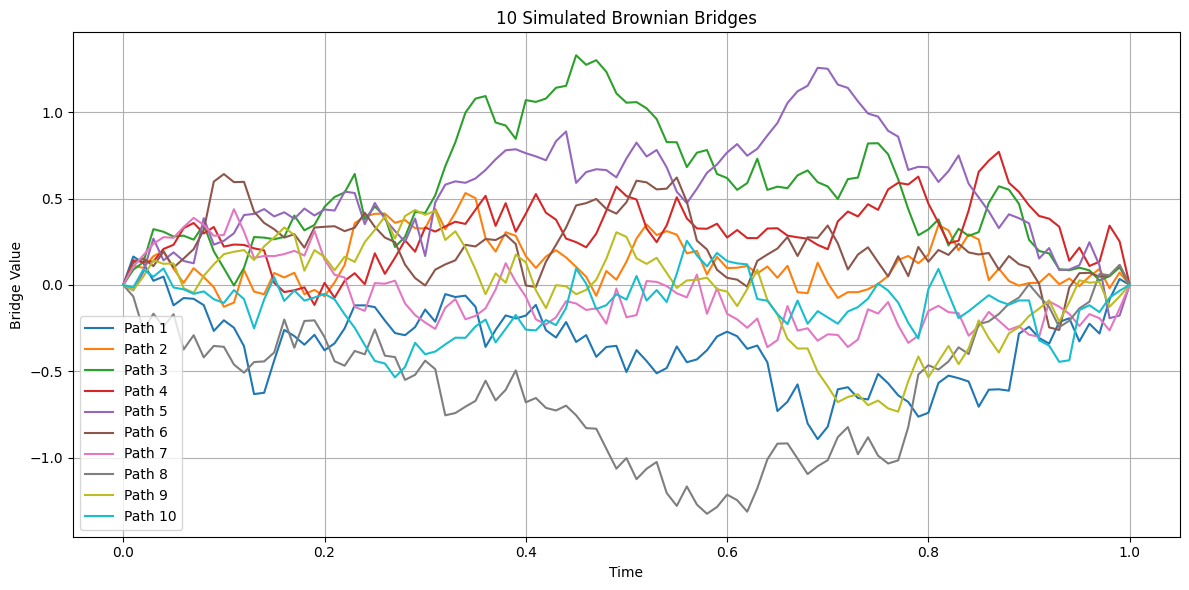

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_brownian_bridge(n_paths=10, m=100, start=0.0, end=0.0, T=1.0):
    """
    Simulates Brownian bridges.

    Parameters:
    - n_paths: Number of Brownian bridge paths to simulate.
    - m: Number of time steps.
    - start: Starting point of the bridge.
    - end: Ending point of the bridge.
    - T: Total time duration.

    Returns:
    - t: Array of time points.
    - bridges: Array of shape (n_paths, m+1) containing the simulated bridges.
    """
    dt = T / m
    t = np.linspace(0, T, m + 1)  # Time grid

    # Generate random increments for Brownian motion
    dW = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(n_paths, m))
    W = np.cumsum(dW, axis=1)  # Cumulative sum to get Brownian paths
    W = np.hstack((np.zeros((n_paths, 1)), W))  # Insert W(0) = 0

    # Adjust to form a Brownian bridge
    # B(t) = W(t) - t/T * W(T) + (t/T) * end + (1 - t/T) * start
    bridges = W - (t / T) * W[:, -1].reshape(-1, 1)
    bridges += start + (t / T) * (end - start)

    return t, bridges

def plot_brownian_bridges(t, bridges, n_paths=10):
    """
    Plots Brownian bridges.

    Parameters:
    - t: Array of time points.
    - bridges: Array containing the simulated bridges.
    - n_paths: Number of paths to plot.
    """
    plt.figure(figsize=(12, 6))
    for i in range(n_paths):
        plt.plot(t, bridges[i], lw=1.5, label=f'Path {i+1}' if i < 10 else "")  # Label only first 10

    plt.title(f'{n_paths} Simulated Brownian Bridges')
    plt.xlabel('Time')
    plt.ylabel('Bridge Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Parameters
    n_paths = 10  # Number of Brownian bridge paths
    m = 100       # Number of steps

    # Simulate Brownian bridges
    t, bridges = simulate_brownian_bridge(n_paths=n_paths, m=m, start=0.0, end=0.0, T=1.0)

    # Plot the simulated bridges
    plot_brownian_bridges(t, bridges, n_paths=n_paths)


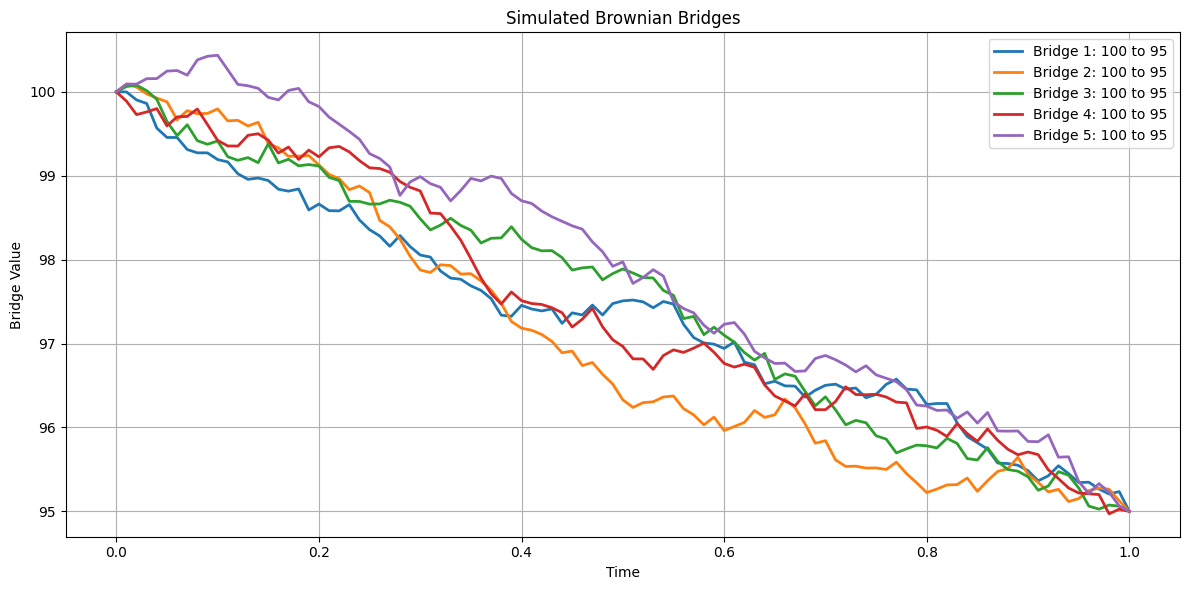

In [71]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_multiple_brownian_bridges(start_points, end_points, m=100, T=1.0):
    """
    Simulates multiple Brownian bridges, each defined by its own start and end points.

    Parameters:
    - start_points: List or array of starting points for each bridge.
    - end_points: List or array of ending points for each bridge.
    - m: Number of time steps (default: 100).
    - T: Total time duration (default: 1.0).

    Returns:
    - t: NumPy array of time points, shape (m+1,).
    - bridges: NumPy array of simulated bridges, shape (n_bridges, m+1).
    """
    # Validate inputs
    if len(start_points) != len(end_points):
        raise ValueError("start_points and end_points must have the same length.")
    
    n_bridges = len(start_points)
    start_points = np.array(start_points).reshape(n_bridges, 1)  # Shape: (n_bridges, 1)
    end_points = np.array(end_points).reshape(n_bridges, 1)      # Shape: (n_bridges, 1)
    
    dt = T / m
    t = np.linspace(0, T, m + 1)  # Time grid, shape: (m+1,)
    
    # Step 1: Generate random increments for standard Brownian motion
    dW = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(n_bridges, m))  # Shape: (n_bridges, m)
    W = np.cumsum(dW, axis=1)  # Cumulative sum to get W(t), shape: (n_bridges, m)
    W = np.hstack((np.zeros((n_bridges, 1)), W))  # Insert W(0) = 0, shape: (n_bridges, m+1)
    
    # Step 2: Adjust W(t) to form a Brownian bridge B(t) for each path
    # Formula: B(t) = W(t) - (t/T) * W(T) + (t/T) * end + (1 - t/T) * start
    t_over_T = t / T  # Shape: (m+1,)
    
    # Reshape t_over_T for broadcasting
    t_over_T = t_over_T.reshape(1, -1)  # Shape: (1, m+1)
    
    # Adjust W(t) by removing the drift to form the bridge
    bridges = W - t_over_T * W[:, -1].reshape(n_bridges, 1)  # Shape: (n_bridges, m+1)
    
    # Add the linear interpolation between start and end points
    bridges += start_points + t_over_T * (end_points - start_points)  # Shape: (n_bridges, m+1)
    
    return t, bridges

# Example Usage
if __name__ == "__main__":
    # Define start and end points
    start_points = [100, 100, 100, 100, 100]
    # end_points = [90, 95, 100, 95, 80]
    end_points = [95, 95, 95, 95, 95]
    
    # Number of time steps and total time
    m = 100
    T = 1.0
    
    # Simulate the Brownian bridges
    t, bridges = simulate_multiple_brownian_bridges(start_points, end_points, m=m, T=T)
    
    # Plot the simulated bridges
    plt.figure(figsize=(12, 6))
    for i in range(len(start_points)):
        plt.plot(t, bridges[i], lw=2, label=f'Bridge {i+1}: {start_points[i]} to {end_points[i]}')
    
    plt.title('Simulated Brownian Bridges')
    plt.xlabel('Time')
    plt.ylabel('Bridge Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Estimated European Call Option Price: 19.0246


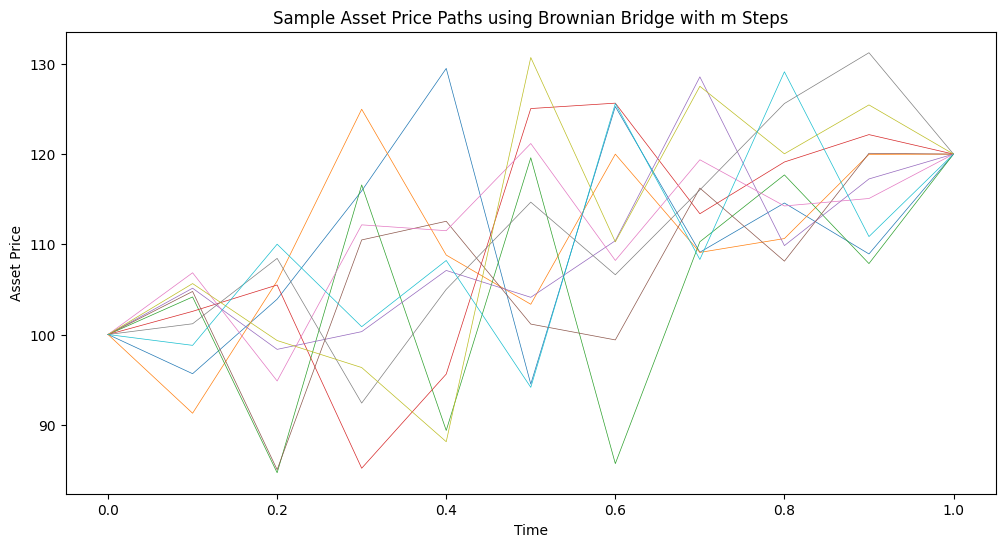

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100        # Initial stock price
K = 100         # Strike price
T = 1.0         # Time to maturity (in years)
r = 0.05        # Risk-free interest rate
sigma = 0.2     # Volatility
n = 10       # Number of simulations
m = 10         # Number of time steps

# Precompute constants
dt = T / m      # Time step size
mu = r - 0.5 * sigma**2
discount_factor = np.exp(-r * T)

# 1. Generate terminal stock prices S_T
Z_T = np.random.normal(size=n)


# S_T = S0 * np.exp(mu * T + sigma * np.sqrt(T) * Z_T)
# TEST //// 1. Set S_T to a fixed value for all simulations
S_T_fixed = 120  # Fixed terminal stock price 
S_T = np.full(n, S_T_fixed)  # Create an array of shape (n,) filled with S_T_fixed

# 2. Calculate corresponding W_T for each S_T
W_T = (np.log(S_T / S0) - mu * T) / sigma

# 3. Generate m time steps
t = np.linspace(0, T, m+1)  # m+1 because we include t=0

# 4. For each simulation, generate Brownian bridge paths
# Initialize an array to store the paths
W = np.zeros((n, m+1))
W[:, 0] = 0  # W(0) = 0

# For each time step (excluding t=0)
for i in range(1, m+1):
    t_i = t[i]
    # Compute mean and variance of W(t_i) given W(T)
    mean = (t_i / T) * W_T
    variance = t_i * (1 - t_i / T)
    std_dev = np.sqrt(variance)
    # Sample W(t_i) for all simulations
    Z = np.random.normal(size=n)
    W[:, i] = mean + std_dev * Z

# 5. Compute stock price paths
S = np.zeros((n, m+1))
for i in range(m+1):
    t_i = t[i]
    S[:, i] = S0 * np.exp( mu * t_i + sigma * W[:, i] )

# 6. Compute payoffs at maturity
payoffs = np.maximum(S[:, -1] - K, 0)

# 7. Estimate the option price
option_price = discount_factor * np.mean(payoffs)

print(f"Estimated European Call Option Price: {option_price:.4f}")

# 8. Plot sample paths
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(t, S[i], lw=0.5)
plt.xlabel('Time')
plt.ylabel('Asset Price')
plt.title('Sample Asset Price Paths using Brownian Bridge with m Steps')
plt.show()


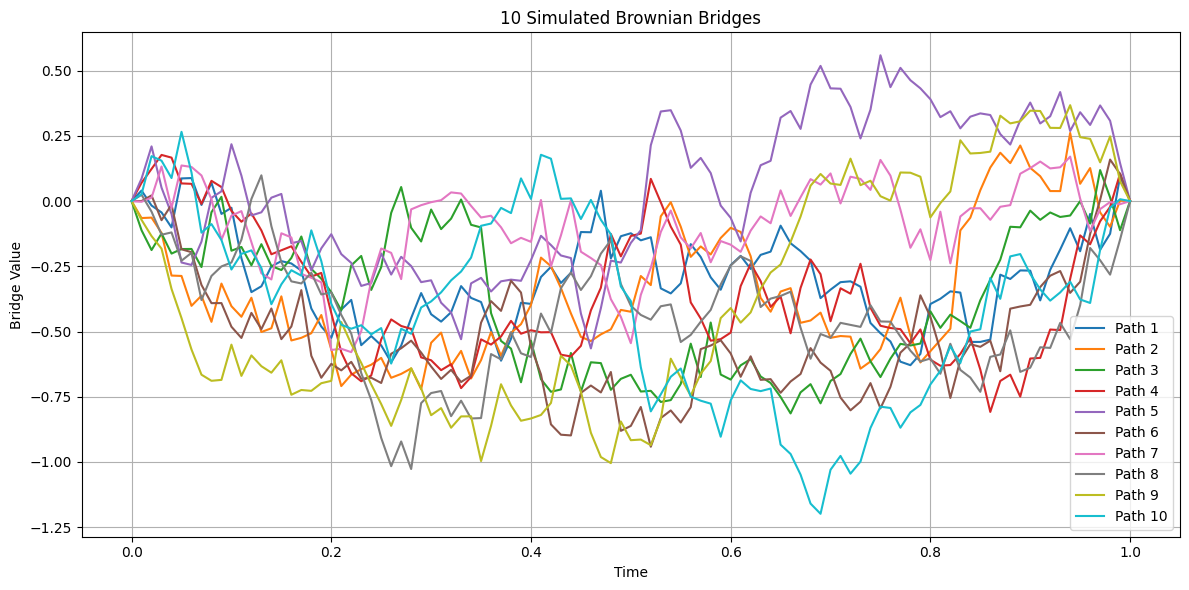

In [67]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_brownian_bridge(n_paths=10, m=100, start=0.0, end=0.0, T=1.0):
    """
    Simulates Brownian bridges.

    Parameters:
    - n_paths: Number of Brownian bridge paths to simulate.
    - m: Number of time steps.
    - start: Starting point of the bridge.
    - end: Ending point of the bridge.
    - T: Total time duration.

    Returns:
    - t: Array of time points.
    - bridges: Array of shape (n_paths, m+1) containing the simulated bridges.
    """
    dt = T / m
    t = np.linspace(0, T, m + 1)  # Time grid

    # Generate random increments for Brownian motion
    dW = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(n_paths, m))
    W = np.cumsum(dW, axis=1)  # Cumulative sum to get Brownian paths
    W = np.hstack((np.zeros((n_paths, 1)), W))  # Insert W(0) = 0

    # Adjust to form a Brownian bridge
    # B(t) = W(t) - t/T * W(T) + (t/T) * end + (1 - t/T) * start
    bridges = W - (t / T) * W[:, -1].reshape(-1, 1)
    bridges += start + (t / T) * (end - start)

    return t, bridges

def plot_brownian_bridges(t, bridges, n_paths=10):
    """
    Plots Brownian bridges.

    Parameters:
    - t: Array of time points.
    - bridges: Array containing the simulated bridges.
    - n_paths: Number of paths to plot.
    """
    plt.figure(figsize=(12, 6))
    for i in range(n_paths):
        plt.plot(t, bridges[i], lw=1.5, label=f'Path {i+1}' if i < 10 else "")  # Label only first 10

    plt.title(f'{n_paths} Simulated Brownian Bridges')
    plt.xlabel('Time')
    plt.ylabel('Bridge Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Parameters
    n_paths = 10  # Number of Brownian bridge paths
    m = 100       # Number of steps

    # Simulate Brownian bridges
    t, bridges = simulate_brownian_bridge(n_paths=n_paths, m=m, start=0.0, end=0.0, T=1.0)

    # Plot the simulated bridges
    plot_brownian_bridges(t, bridges, n_paths=n_paths)


Estimated European Call Option Price: 10.2220


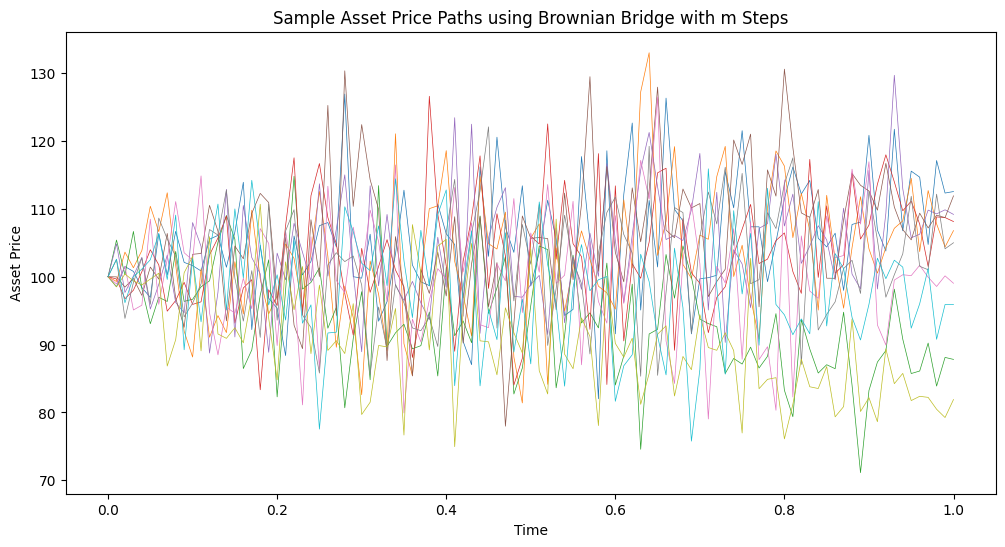

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100        # Initial stock price
K = 100         # Strike price
T = 1.0         # Time to maturity (in years)
r = 0.05        # Risk-free interest rate
sigma = 0.2     # Volatility
n = 10000       # Number of simulations
m = 100         # Number of time steps

# Precompute constants
dt = T / m      # Time step size
mu = r - 0.5 * sigma**2
discount_factor = np.exp(-r * T)

# 1. Generate terminal stock prices S_T
Z_T = np.random.normal(size=n)
S_T = S0 * np.exp(mu * T + sigma * np.sqrt(T) * Z_T)

# 2. Calculate corresponding W_T for each S_T
W_T = (np.log(S_T / S0) - mu * T) / sigma

# 3. Generate time steps
t = np.linspace(0, T, m+1)  # Shape (m+1,)

# 4. Compute t/T and sqrt of variance for Brownian bridge
t_over_T = t / T  # Shape (m+1,)
sqrt_variance = np.sqrt(t * (1 - t_over_T))  # Shape (m+1,)

# 5. Generate standard normal random variables Z for Brownian bridge
Z = np.random.normal(size=(n, m+1))  # Shape (n, m+1)

# 6. Generate Brownian bridge paths B(t) using vectorized operations
B = t_over_T[np.newaxis, :] * W_T[:, np.newaxis] + sqrt_variance[np.newaxis, :] * Z

# 7. Compute stock price paths S(t)
S = S0 * np.exp(mu * t[np.newaxis, :] + sigma * B)

# 8. Compute payoffs at maturity
payoffs = np.maximum(S[:, -1] - K, 0)

# 9. Estimate the option price
option_price = discount_factor * np.mean(payoffs)

print(f"Estimated European Call Option Price: {option_price:.4f}")

# 10. Plot sample paths
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(t, S[i], lw=0.5)
plt.xlabel('Time')
plt.ylabel('Asset Price')
plt.title('Sample Asset Price Paths using Brownian Bridge with m Steps')
plt.show()


Estimated European Call Option Price: 19.0246


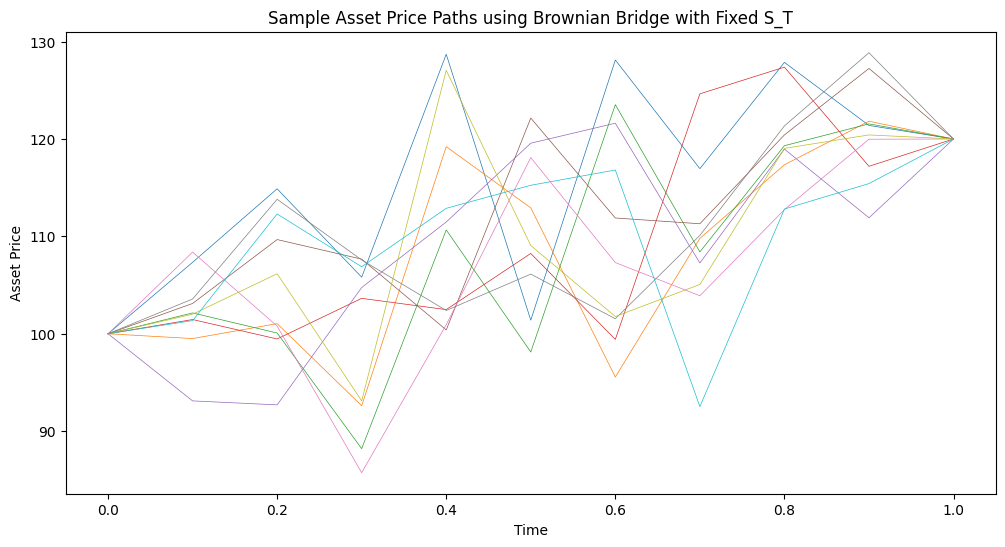

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100        # Initial stock price
K = 100         # Strike price
T = 1.0         # Time to maturity (in years)
r = 0.05        # Risk-free interest rate
sigma = 0.2     # Volatility
n = 10       # Number of simulations
m = 10         # Number of time steps

# Precompute constants
dt = T / m      # Time step size
mu = r - 0.5 * sigma**2
discount_factor = np.exp(-r * T)

# 1. Set S_T to a fixed value for all simulations
S_T_fixed = 120  # Fixed terminal stock price
S_T = np.full(n, S_T_fixed)  # Create an array of shape (n,) filled with S_T_fixed

# 2. Calculate corresponding W_T for the fixed S_T
W_T = (np.log(S_T / S0) - mu * T) / sigma  # This will be the same for all simulations

# 3. Generate time steps
t = np.linspace(0, T, m+1)  # Shape (m+1,)

# 4. Compute t/T and sqrt of variance for Brownian bridge
t_over_T = t / T  # Shape (m+1,)
sqrt_variance = np.sqrt(t * (1 - t_over_T))  # Shape (m+1,)

# 5. Generate standard normal random variables Z for Brownian bridge
Z = np.random.normal(size=(n, m+1))  # Shape (n, m+1)

# 6. Generate Brownian bridge paths B(t) using vectorized operations
B = t_over_T[np.newaxis, :] * W_T[:, np.newaxis] + sqrt_variance[np.newaxis, :] * Z

# 7. Compute stock price paths S(t)
S = S0 * np.exp(mu * t[np.newaxis, :] + sigma * B)

# 8. Compute payoffs at maturity
payoffs = np.maximum(S[:, -1] - K, 0)  # All payoffs will be the same since S_T is fixed

# 9. Estimate the option price
option_price = discount_factor * np.mean(payoffs)

print(f"Estimated European Call Option Price: {option_price:.4f}")

# 10. Plot sample paths
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(t, S[i], lw=0.5)
plt.xlabel('Time')
plt.ylabel('Asset Price')
plt.title('Sample Asset Price Paths using Brownian Bridge with Fixed S_T')
plt.show()


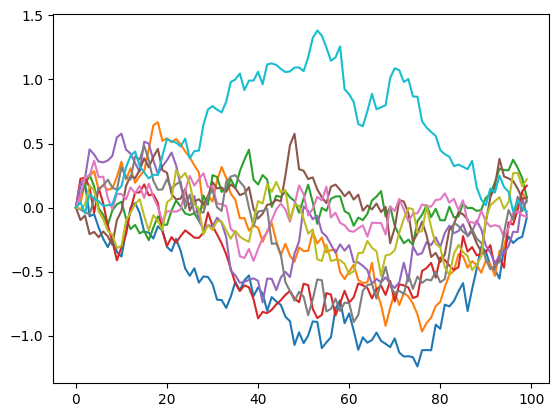

In [30]:
#!/usr/bin/env python                                                                                                                                                                                              

import numpy
import six
from matplotlib import pyplot


seed = 0
N = 100
M = 10

numpy.random.seed(seed)


def sample_path_batch(M, N):
    dt = 1.0 / N
    dt_sqrt = numpy.sqrt(dt)
    B = numpy.empty((M, N), dtype=numpy.float32)
    B[:, 0] = 0
    for n in six.moves.range(N - 1):
        t = n * dt
        xi = numpy.random.randn(M) * dt_sqrt
        B[:, n + 1] = B[:, n] * (1 - dt / (1 - t)) + xi
    return B


B = sample_path_batch(M, N)
pyplot.plot(B.T)
pyplot.show()

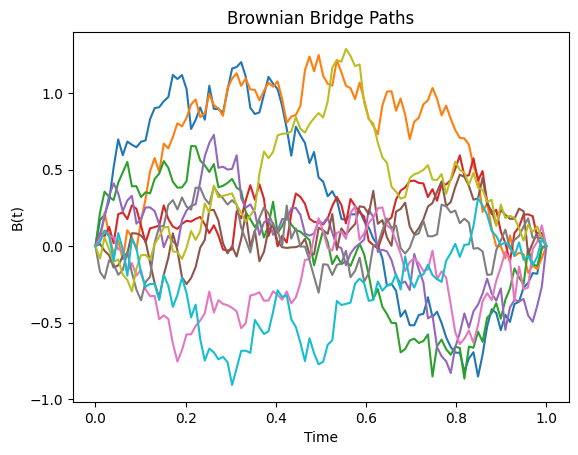

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
seed = 0
N = 100  # Number of time steps
M = 10   # Number of paths

np.random.seed(seed)

def sample_path_batch_vectorized(M, N):
    dt = 1.0 / N
    dt_sqrt = np.sqrt(dt)
    t = np.linspace(0, 1, N)  # Time grid from 0 to 1

    # 1. Generate standard Brownian motion increments
    dW = np.random.randn(M, N - 1) * dt_sqrt  # Shape: (M, N-1)

    # 2. Compute cumulative sum to get W(t)
    W = np.hstack((np.zeros((M, 1)), np.cumsum(dW, axis=1)))  # Shape: (M, N)

    # 3. Get W(T) for each path (last value in each row)
    W_T = W[:, -1].reshape(M, 1)  # Shape: (M, 1)

    # 4. Compute Brownian bridge B(t) using vectorized operations
    t = t.reshape(1, N)  # Shape: (1, N)
    B = W - t * W_T      # Shape: (M, N)

    return B

# Generate Brownian bridge paths
B = sample_path_batch_vectorized(M, N)

# Plot the paths
# plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, 1, N), B.T)
plt.xlabel('Time')
plt.ylabel('B(t)')
plt.title('Brownian Bridge Paths')
plt.show()


In [51]:
import numpy as np
import matplotlib.pyplot as plt

def brownian_bridge_european_call(S0, K, T, r, sigma, n, m):
    """
    Simulate Brownian bridge paths for a European call option and estimate its price.

    Parameters:
    S0 (float): Initial stock price.
    K (float): Strike price.
    T (float): Time to maturity.
    r (float): Risk-free interest rate.
    sigma (float): Volatility.
    n (int): Number of simulations.
    m (int): Number of time steps.

    Returns:
    option_price (float): Estimated European call option price.
    t (np.ndarray): Time grid array.
    S (np.ndarray): Simulated stock price paths.
    """

    # 1. Time Grid
    t = np.linspace(0, T, m + 1)  # m steps, m+1 points
    dt = T / m

    # 2. Simulate Terminal Stock Prices S_T
    Z_T = np.random.normal(size=n)  # Shape: (n,)
    S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_T)  # Shape: (n,)

    # 3. Compute Midpoints S_mid
    S_mid_mean = (S0 + S_T) / 2.0  # Shape: (n,)
    var_mid = (sigma**2 * T) / 4.0  # Variance at midpoint t = T/2
    std_mid = np.sqrt(var_mid)  # Standard deviation at midpoint

    # 4. Sample Midpoint Selections S_mid from N(S_mid_mean, var_mid)
    S_mid = S_mid_mean + std_mid * np.random.normal(size=n)  # Shape: (n,)

    # 5. Construct Paths Using Vectorized Operations
    # Split the time grid into two halves: 0 to T/2 and T/2 to T
    mid_idx = m // 2
    m1 = mid_idx
    m2 = m - m1

    # a. First Half: 0 to T/2
    t1 = t[:mid_idx + 1]  # Time from 0 to T/2, shape: (m1 +1,)
    mu1 = (r - 0.5 * sigma**2) * t1[1:]  # Drift term, shape: (m1,)

    # Generate Brownian increments for the first half
    Z1 = np.random.normal(size=(n, m1))  # Shape: (n, m1)
    W1 = np.cumsum(Z1 * np.sqrt(dt), axis=1)  # Cumulative Brownian motion, shape: (n, m1)

    # Compute log stock prices for the first half
    log_S1 = np.log(S0) + mu1.reshape(1, m1) + sigma * W1  # Shape: (1, m1) + (n, m1) via broadcasting
    S1 = np.exp(log_S1)  # Shape: (n, m1)

    # Enforce S_mid as the last point of the first half
    S1[:, -1] = S_mid  # Shape: (n, m1)

    # b. Second Half: T/2 to T
    t2 = t[mid_idx:m + 1]  # Time from T/2 to T, shape: (m2 +1,)
    mu2 = (r - 0.5 * sigma**2) * (t2[1:] - T / 2)  # Drift term relative to T/2, shape: (m2,)

    # Generate Brownian increments for the second half
    Z2 = np.random.normal(size=(n, m2))  # Shape: (n, m2)
    W2 = np.cumsum(Z2 * np.sqrt(dt), axis=1)  # Cumulative Brownian motion, shape: (n, m2)

    # Compute log stock prices for the second half
    log_S2 = np.log(S_mid).reshape(n, 1) + mu2.reshape(1, m2) + sigma * W2  # Shape: (n, m2)
    S2 = np.exp(log_S2)  # Shape: (n, m2)

    # Enforce S_T as the last point of the second half
    S2[:, -1] = S_T  # Shape: (n, m2)

    # Combine the two halves, excluding the duplicate midpoint
    # S1 has (n, m1), S2 has (n, m2)
    # To have total m+1 points, combine S1[:, :-1] and S2
    S = np.hstack((S1[:, :-1], S2))  # Shape: (n, m +1)

    # 6. Compute Payoffs at Maturity
    payoffs = np.maximum(S[:, -1] - K, 0)  # Shape: (n,)

    # 7. Estimate the Option Price
    discount_factor = np.exp(-r * T)
    option_price = discount_factor * np.mean(payoffs)

    return option_price, t, S


In [53]:
S0 = 100        # Initial stock price
K = 100         # Strike price
T = 1.0         # Time to maturity (in years)
r = 0.05        # Risk-free interest rate
sigma = 0.2     # Volatility
n = 10000       # Number of simulations
m = 100         # Number of time steps

# Seed for reproducibility
np.random.seed(42)

# Price the option
option_price, t, S = brownian_bridge_european_call(S0, K, T, r, sigma, n, m)

In [56]:
S.shape

(10000, 99)

In [60]:
len(t)

101

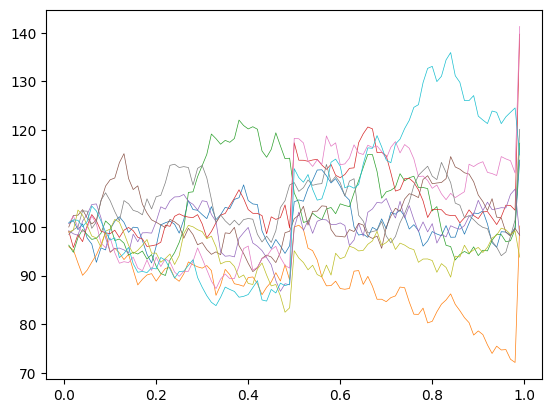

In [61]:
num_samples = 10

for i in range(num_samples):
    plt.plot(t[1:-1], S[i], lw=0.5)

Estimated European Call Option Price: 10.4502


ValueError: x and y must have same first dimension, but have shapes (101,) and (99,)

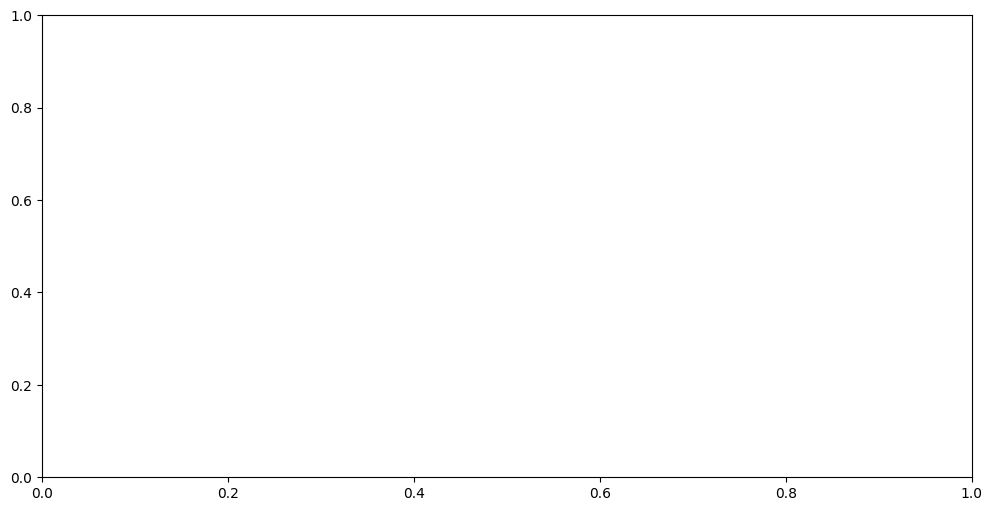

In [52]:

# Example Usage
if __name__ == "__main__":
    # Parameters
    S0 = 100        # Initial stock price
    K = 100         # Strike price
    T = 1.0         # Time to maturity (in years)
    r = 0.05        # Risk-free interest rate
    sigma = 0.2     # Volatility
    n = 10000       # Number of simulations
    m = 100         # Number of time steps

    # Seed for reproducibility
    np.random.seed(42)

    # Price the option
    option_price, t, S = brownian_bridge_european_call(S0, K, T, r, sigma, n, m)

    print(f"Estimated European Call Option Price: {option_price:.4f}")

    # Plot sample paths
    plt.figure(figsize=(12, 6))
    num_samples = 10  # Number of sample paths to plot
    for i in range(num_samples):
        plt.plot(t, S[i], lw=0.5)
    plt.xlabel('Time')
    plt.ylabel('Asset Price')
    plt.title('Sample Asset Price Paths using Vectorized Brownian Bridge')
    plt.show()


Estimated European Call Option Price with Fixed S_T (120): 19.0246


ValueError: x and y must have same first dimension, but have shapes (101,) and (99,)

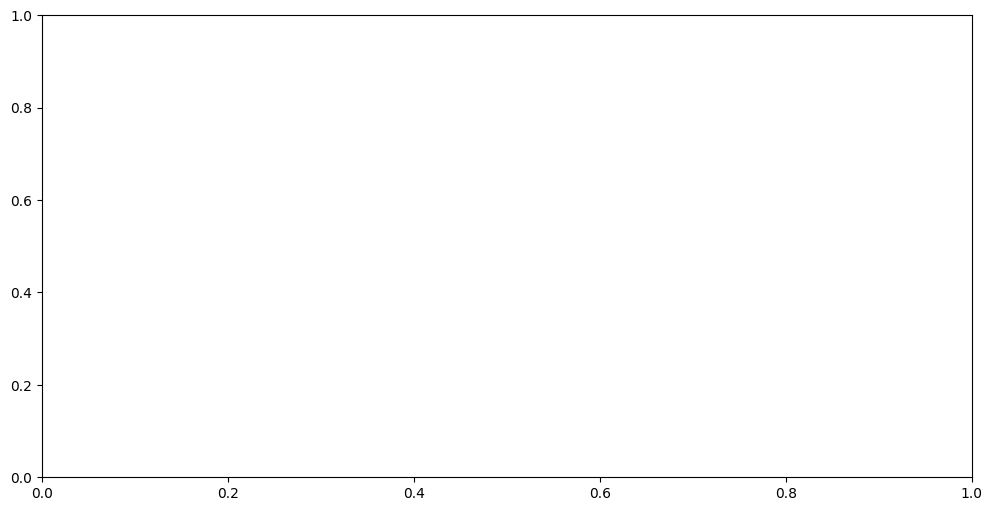

In [49]:
if __name__ == "__main__":
    # Parameters
    S0 = 100        # Initial stock price
    K = 100         # Strike price
    T = 1.0         # Time to maturity (in years)
    r = 0.05        # Risk-free interest rate
    sigma = 0.2     # Volatility
    n = 10000       # Number of simulations
    m = 100         # Number of time steps
    fixed_S_T = 120 # Fixed terminal stock price

    # Seed for reproducibility
    np.random.seed(42)

    # Price the option with fixed S_T
    option_price_fixed, t_fixed, S_fixed = brownian_bridge_european_call_fixed_S_T(
        S0, K, T, r, sigma, n, m, fixed_S_T
    )

    print(f"Estimated European Call Option Price with Fixed S_T ({fixed_S_T}): {option_price_fixed:.4f}")

    # Plot sample paths
    plt.figure(figsize=(12, 6))
    num_samples = 10  # Number of sample paths to plot
    for i in range(num_samples):
        plt.plot(t_fixed, S_fixed[i], lw=0.5)
    plt.xlabel('Time')
    plt.ylabel('Asset Price')
    plt.title('Sample Asset Price Paths using Vectorized Brownian Bridge with Fixed S_T')
    plt.show()


In [11]:
# 시뮬레이션방법론 최종과제 소스코드
# 20249132 김형환

import numpy as np
import scipy.stats as sst

def mc_barrier_price_형환(s, k, r, q, t, sigma, option_flag, n, b, barrier_flag, m):
    
    # Set parameters
    dt = t/m
    dts = np.arange(dt, t+dt, dt)
    barrier_up, barrier_out = barrier_flag.startswith('up'), barrier_flag.endswith('out')
    option_call = option_flag.lower() == 'call'
    option_type = 1 if option_call else -1
    moneyness_otm = 1 if option_type * (k - (1 + option_type * 0.2 * np.sqrt(t) * sigma) * s) >= 0 else 0
    
    # (1) Stratified sampling, z_t makes price at T & z makes brownian bridge
    z_t = sst.norm.ppf((np.arange(n) + np.random.uniform(0,1,n)) / n)
    z = np.random.randn(n,m)
    
    # (2) Moment matching in z_t
    z_t = np.where(n>=100, (z_t - z_t.mean()) / z_t.std(ddof=1), z_t - z_t.mean())
    
    # (3) Antithetic variate
    z_t, z = np.concatenate([z_t, -z_t], axis=0), np.concatenate([z, -z], axis=0)
    
    # (4) Importance sampling at z_t
    if barrier_out:
        if moneyness_otm: mu = (np.log(k/s) - (r-q-0.5*sigma**2)*t) / (sigma*np.sqrt(t))
        else: mu = 0 # Knock-out & ATM, OTM then importance sampling is not applied.
    else:
        if barrier_up + option_call == 1: mu = 0 # Down-In call & Up-In put are not applied.
        else: mu = (np.log(b/s) - (r-q-0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    z_t = z_t + mu
    likelihood_ratio = np.exp(-mu*z_t + 0.5*mu**2)
    
    # Generate underlying paths using brownian bridge
    w_t, w = z_t * np.sqrt(t), z.cumsum(axis=1) * np.sqrt(dt) # winner process
    bridge = dts * ((w_t- w[:,-1]).reshape(len(w),1) + w / dts) # brownian bridge
    paths = s*np.exp((r-q-0.5*sigma**2)*dts + sigma*bridge) # underlying price path

    # Determine whether barrier touch or not (exists payoff or not)
    if barrier_up: knock = paths.max(axis=1) >= b
    else: knock = paths.min(axis=1) <= b
    if barrier_out: knock = ~knock
    
    # Caculate options payoff
    plain_npv = np.maximum(option_type*(paths[:,-1]-k), 0) * np.exp(-r*t) * likelihood_ratio
    barrier_npv = knock * plain_npv
    
    # (5) Control variate using plain vanilla options
    d1 = (np.log(s/k) + (r - q + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    nd1, nd2 = sst.norm.cdf(option_type*d1), sst.norm.cdf(option_type*d2)
    plain_bsprice = option_type*(s*np.exp(-q*t)*nd1 - k*np.exp(-r*t)*nd2)
    
    cov_npv = np.cov(barrier_npv,plain_npv,ddof=1)
    beta = np.where(cov_npv[1,1]==0,0,cov_npv[0,1] / cov_npv[1,1])
    barrier_CVnpv = barrier_npv - beta * (plain_npv - plain_bsprice)

    barrier_price = barrier_CVnpv.mean()

    return barrier_price

## Performance 비교

In [7]:
import numpy as np
import time
import QuantLib as ql

def compare_barrier_option_pricing(mc_barrier_option, N, n, s, k, r, q, t, sigma,
                                   option_flag, b, barrier_flag, m):
    """
    Compare custom MCS barrier option pricing with QuantLib pricing.

    Parameters:
        mc_barrier_option (function): Custom MCS pricing function.
        N (int): Number of simulations (number of times to run MCS).
        n (int): Number of paths per MCS simulation.
        s (float): Initial stock price.
        k (float): Strike price.
        r (float): Risk-free interest rate.
        q (float): Dividend yield.
        t (float): Time to maturity.
        sigma (float): Volatility.
        option_flag (str): 'call' or 'put'.
        b (float): Barrier level.
        barrier_flag (str): 'up-in', 'up-out', 'down-in', or 'down-out'.
        m (int): Number of time steps for discretization.

    Returns:
        dict: A dictionary containing bias, variance, and timing statistics.
    """
    # Initialize lists to store results
    mcs_prices = []
    mcs_times = []

    # Set up QuantLib barrier option once, as it doesn't change between simulations
    # Convert option parameters to QuantLib types
    option_type = ql.Option.Call if option_flag.lower() == 'call' else ql.Option.Put
    barrier_type_map = {
        'up-in': ql.Barrier.UpIn,
        'up-out': ql.Barrier.UpOut,
        'down-in': ql.Barrier.DownIn,
        'down-out': ql.Barrier.DownOut
    }
    barrier_type = barrier_type_map[barrier_flag.lower()]
    rebate = 0.0  # Assuming zero rebate

    # Set up QuantLib components
    calculation_date = ql.Date.todaysDate()
    ql.Settings.instance().evaluationDate = calculation_date

    # Create QuantLib objects
    day_count = ql.Actual365Fixed()
    calendar = ql.NullCalendar()
    maturity_date = calculation_date + ql.Period(int(t * 365 + 0.5), ql.Days)

    payoff = ql.PlainVanillaPayoff(option_type, k)
    exercise = ql.EuropeanExercise(maturity_date)
    barrier_option = ql.BarrierOption(barrier_type, b, rebate, payoff, exercise)

    # Set up the market data
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(s))
    flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, r, day_count))
    dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, q, day_count))
    flat_vol_ts = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(calculation_date, calendar, sigma, day_count)
    )
    bsm_process = ql.BlackScholesMertonProcess(
        spot_handle, dividend_yield, flat_ts, flat_vol_ts
    )

    # Choose the analytical engine
    engine = ql.AnalyticBarrierEngine(bsm_process)
    barrier_option.setPricingEngine(engine)

    # Compute the QuantLib price once (as it doesn't change)
    start_time = time.time()
    quantlib_price = barrier_option.NPV()
    end_time = time.time()
    quantlib_time = (end_time - start_time) * 1000  # Convert to milliseconds

    for _ in range(N):
        # Time the MCS pricing function
        start_time = time.time()
        mcs_price = mc_barrier_option(s, k, r, q, t, sigma, option_flag, n, b, barrier_flag, m)
        end_time = time.time()
        mcs_time = (end_time - start_time) * 1000  # Convert to milliseconds

        # Store the results
        mcs_prices.append(mcs_price)
        mcs_times.append(mcs_time)

    # Calculate bias and variance
    mcs_prices = np.array(mcs_prices)
    mcs_times = np.array(mcs_times)

    bias = np.mean(mcs_prices) - quantlib_price
    variance = np.var(mcs_prices, ddof=1)

    # Calculate timing statistics
    mcs_time_mean = np.mean(mcs_times)
    mcs_time_std = np.std(mcs_times, ddof=1)
    quantlib_time_mean = quantlib_time
    quantlib_time_std = 0.0  # Since it's computed once

    # Prepare results
    results = {
        'bias': bias,
        'variance': variance,
        'mcs_time_mean_ms': mcs_time_mean,
        'mcs_time_std_ms': mcs_time_std,
        'quantlib_time_mean_ms': quantlib_time_mean,
        'quantlib_time_std_ms': quantlib_time_std,
        'quantlib_price': quantlib_price,
        'mcs_price_mean': np.mean(mcs_prices)
    }

    # Print the results
    print("Bias between MCS and QuantLib price: {:.6f}".format(bias))
    print("Variance of MCS prices: {:.6f}".format(variance))
    print("MCS computation time (mean ± std): {:.2f} ms ± {:.2f} ms".format(mcs_time_mean, mcs_time_std))
    print("QuantLib computation time: {:.2f} ms".format(quantlib_time_mean))
    print("QuantLib Barrier Option Price: {:.6f}".format(quantlib_price))
    print("Mean MCS Barrier Option Price: {:.6f}".format(np.mean(mcs_prices)))

    return results


In [37]:

# class BrownianBridgeFractal:

#     def __init__(
#         self,
#         start: tuple,
#         end: tuple,
#         sigma: float=1.0,
#         depth: int=10
#     ) -> None:
#         self.start = start
#         self.end = end
#         self.sigma = sigma
#         self.depth = depth
#         self.times_steps = np.linspace(0, end[0] - start[0], num=2**depth+1)

#     def build_intermediate(self, starting_array: np.ndarray) -> np.ndarray:
#         new_bits = np.ndarray((2, starting_array.shape[1] - 1))
#         noise = np.random.normal(size=starting_array.shape[1] - 1)
#         new_bits[0] = (starting_array[0][:-1]+starting_array[0][1:])/2.0
#         mu = (starting_array[1][:-1]+starting_array[1][1:])/2.0
#         this_sigma = np.sqrt(
#             (starting_array[0][1:]-new_bits[0])*
#             (new_bits[0]-starting_array[0][:-1])/
#             (starting_array[0][1:]-starting_array[0][:-1])
#         )
#         tobereturned = np.ndarray((2, 2*starting_array.shape[1] - 1))
        
#         tobereturned[0][0::2] = starting_array[0]
#         tobereturned[0][1::2] = new_bits[0]
#         tobereturned[1][0::2] = starting_array[1]
#         tobereturned[1][1::2] = mu + this_sigma*self.sigma*noise

#         return tobereturned

#     def sample(self) -> np.array:
#         working_array = np.ndarray((2, 2))
#         working_array[0] = np.array([self.start[0], self.end[0]])
#         working_array[1] = np.array([self.start[1], self.end[1]])
#         for i in range(self.depth):
#             working_array = self.build_intermediate(working_array)

#         return working_array[1]

In [39]:
sample = BrownianBridgeFractal((0,2),(6, 8), sigma=3, depth=3 ).sample()

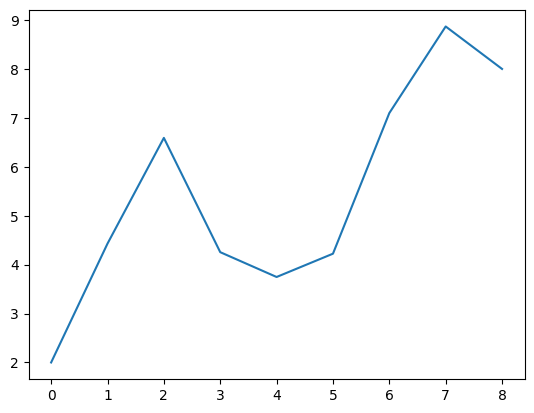

In [41]:
plt.plot(sample)

### Baseline

In [8]:

# Example usage:
if __name__ == '__main__':
    # Assume mc_barrier_price is defined as per the corrected implementation
    import numpy as np
    from blackscholes import bsprice

    # Include your corrected mc_barrier_price function here or import it if defined elsewhere

    # Testing parameters
    s = 100      # Initial stock price
    k = 105      # Strike price
    r = 0.05     # Risk-free rate
    q = 0.02     # Dividend yield
    t = 1.0      # Time to maturity
    sigma = 0.2  # Volatility
    option_flag = 'call'
    b = 110      # Barrier level
    barrier_flag = 'up-in'
    m = 2**9     # Number of time steps (512)
    n = 2**9     # Number of paths per simulation (512)
    N = 30       # Number of simulations

    print("교수님 baseline:")
    results = compare_barrier_option_pricing(mc_barrier_price_baseline, N, n, s, k, r, q, t, sigma,
                                             option_flag, b, barrier_flag, m)


교수님 baseline:
Bias between MCS and QuantLib price: 0.022933
Variance of MCS prices: 0.301201
MCS computation time (mean ± std): 8.18 ms ± 0.98 ms
QuantLib computation time: 4.00 ms
QuantLib Barrier Option Price: 6.972397
Mean MCS Barrier Option Price: 6.995330


### 내꺼

In [15]:

# Example usage:
if __name__ == '__main__':
    # Assume mc_barrier_price is defined as per the corrected implementation
    import numpy as np
    from blackscholes import bsprice

    # Include your corrected mc_barrier_price function here or import it if defined elsewhere

    # Testing parameters
    s = 90      # Initial stock price
    k = 105      # Strike price
    r = 0.05     # Risk-free rate
    q = 0.02     # Dividend yield
    t = 1.0      # Time to maturity
    sigma = 0.2  # Volatility
    option_flag = 'call'
    b = 110      # Barrier level
    barrier_flag = 'up-in'
    m = 2**9     # Number of time steps (512)
    n = 2**9     # Number of paths per simulation (512)
    N = 30       # Number of simulations

    print("내 MCS:")
    results = compare_barrier_option_pricing(mc_barrier_price1, N, n, s, k, r, q, t, sigma,
                                             option_flag, b, barrier_flag, m)


내 MCS:
Bias between MCS and QuantLib price: -0.005977
Variance of MCS prices: 0.000155
MCS computation time (mean ± std): 7.60 ms ± 0.95 ms
QuantLib computation time: 0.00 ms
QuantLib Barrier Option Price: 3.031450
Mean MCS Barrier Option Price: 3.025474


In [16]:

# Example usage:
if __name__ == '__main__':
    # Assume mc_barrier_price is defined as per the corrected implementation
    import numpy as np
    from blackscholes import bsprice

    # Include your corrected mc_barrier_price function here or import it if defined elsewhere

    # Testing parameters
    s = 90      # Initial stock price
    k = 105      # Strike price
    r = 0.05     # Risk-free rate
    q = 0.02     # Dividend yield
    t = 1.0      # Time to maturity
    sigma = 0.2  # Volatility
    option_flag = 'call'
    b = 110      # Barrier level
    barrier_flag = 'up-in'
    m = 2**9     # Number of time steps (512)
    n = 2**9     # Number of paths per simulation (512)
    N = 30       # Number of simulations

    print("내 MCS:")
    results = compare_barrier_option_pricing(mc_barrier_price2, N, n, s, k, r, q, t, sigma,
                                             option_flag, b, barrier_flag, m)


내 MCS:
Bias between MCS and QuantLib price: 0.021303
Variance of MCS prices: 0.000000
MCS computation time (mean ± std): 9.57 ms ± 0.78 ms
QuantLib computation time: 0.00 ms
QuantLib Barrier Option Price: 3.031450
Mean MCS Barrier Option Price: 3.052753


### 다른사람꺼

In [17]:
# 김형환

# Example usage:
if __name__ == '__main__':
    # Assume mc_barrier_price is defined as per the corrected implementation
    import numpy as np
    from blackscholes import bsprice

    # Include your corrected mc_barrier_price function here or import it if defined elsewhere

    # Testing parameters
    s = 90      # Initial stock price
    k = 105      # Strike price
    r = 0.05     # Risk-free rate
    q = 0.02     # Dividend yield
    t = 1.0      # Time to maturity
    sigma = 0.2  # Volatility
    option_flag = 'call'
    b = 110      # Barrier level
    barrier_flag = 'up-in'
    m = 2**9     # Number of time steps (512)
    n = 2**9     # Number of paths per simulation (512)
    N = 30       # Number of simulations

    print("형환 MCS:")
    results = compare_barrier_option_pricing(mc_barrier_price_형환, N, n, s, k, r, q, t, sigma,
                                             option_flag, b, barrier_flag, m)


형환 MCS:
Bias between MCS and QuantLib price: -0.007661
Variance of MCS prices: 0.000045
MCS computation time (mean ± std): 17.21 ms ± 1.11 ms
QuantLib computation time: 0.00 ms
QuantLib Barrier Option Price: 3.031450
Mean MCS Barrier Option Price: 3.023789
